# Exploratory Data Analysis and forecasting of Covid cases in the United States.
(Starting with the first case)
The goal of this analysis is to check for the trend of Covid cases in the United States. The seasonal changes in the rise of cases and possibly mapping it upto events that mightve led to it. One possible outcome could be to use this trend and forecast what it might look like in the future.


In [134]:
from google.colab import files

uploaded = files.upload()

Saving us.csv to us (2).csv


#Checking the dataset

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_squared_log_error, median_absolute_error,
                             r2_score)


##Process Data

In [136]:
df = pd.read_csv("us.csv", index_col=["date"], parse_dates=["date"])
new_df = df.copy()
new_df.tail()

,cases,deaths
date,,
2021-08-11,36308224,618701
2021-08-12,36446819,619723
2021-08-13,36633960,620364
2021-08-14,36684028,621051
2021-08-15,36727846,621228


###Adding a column that has the daily count


In [137]:
new_df['daily_cases'] = abs(new_df['cases'] - new_df["cases"].shift(1))
new_df['daily_death'] = abs(new_df['deaths'] - new_df["deaths"].shift(1))
new_df.fillna(0,inplace=True)
new_df.head()

,cases,deaths,daily_cases,daily_death
date,,,,
2020-01-21,1,0,0.0,0.0
2020-01-22,1,0,0.0,0.0
2020-01-23,1,0,0.0,0.0
2020-01-24,2,0,1.0,0.0
2020-01-25,3,0,1.0,0.0


Checking for null values.

In [109]:
new_df.isna().sum()

cases          0
deaths         0
daily_cases    0
daily_death    0
dtype: int64

In [142]:
new_df.head()

,cases,deaths,daily_cases,daily_death
date,,,,
2020-01-21,1,0,0.0,0.0
2020-01-22,1,0,0.0,0.0
2020-01-23,1,0,0.0,0.0
2020-01-24,2,0,1.0,0.0
2020-01-25,3,0,1.0,0.0


##Plotting a chart of daily covid cases and deaths.

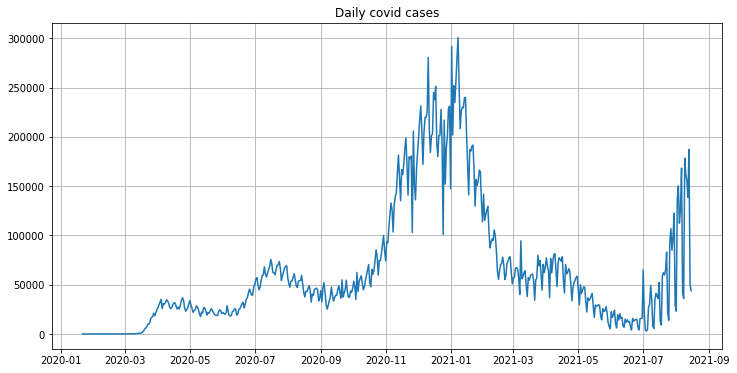

In [111]:
plt.figure(figsize=(12, 6))
plt.plot(new_df["daily_cases"])
plt.title("Daily covid cases")
plt.grid(True)
plt.show()

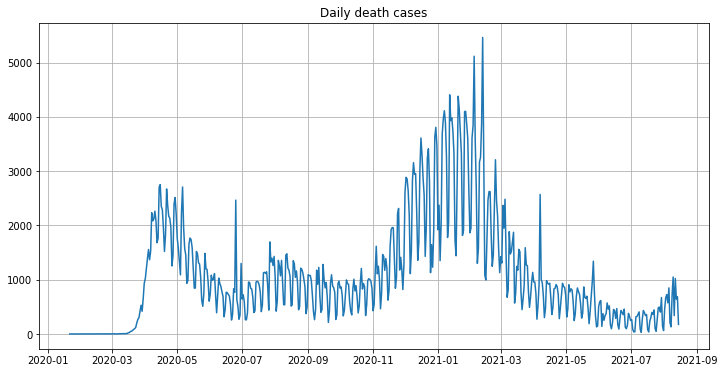

In [112]:
plt.figure(figsize=(12, 6))
plt.plot(new_df["daily_death"])
plt.title("Daily death cases")
plt.grid(True)
plt.show()

##Checking anamolies with box plot.

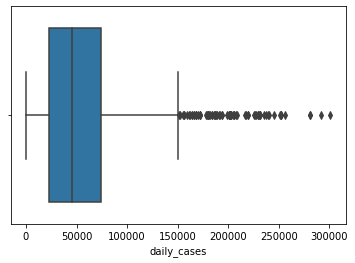

In [113]:
import seaborn as sns
sns.boxplot(x = new_df['daily_cases'])

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 2020-01-21 to 2021-08-15
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   cases   573 non-null    int64
 1   deaths  573 non-null    int64
dtypes: int64(2)
memory usage: 13.4 KB


#Look at stationarity

In the most intuitive sense, stationarity means that the statistical properties of a process generating a time series do not change over time. It does not mean that the series does not change over time, just that the way it changes does not itself change over time. We need to have stationarity in our data to apply models into it.

##Creating a test to check stationarity

In [115]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(new_df,new_param):
  
  rolmean = new_df[new_param].rolling(window=12,center=False).mean()
  rolstd = new_df[new_param].rolling(window=12,center=False).std()

  orig = plt.plot(new_df[new_param],
                  color = 'blue',
                  label = 'original')
  
  mean = plt.plot(rolmean,
                  color = 'red',
                  label = 'Rolling Mean')
  
  std = plt.plot(rolstd,
                 color = 'black',
                 label = 'Rolling Std')
  plt.legend(loc = 'best')
  plt.title('Rolling mean & standard deviation for %s' %(new_param))
  plt.xticks(rotation = 45)
  plt.show(block = False)
  plt.close()

  print("Results of Dickney-Fuller Test:")

  dftest = adfuller(new_df[new_param],
                    autolag = 'AIC' )
  dfoutput = pd.Series(dftest[0:4],
                       index = ['Test Stastistic',
                                'p-value',
                                'Lags Used',
                                'Number of Observation Used'])
  
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)


###Testing stationarity

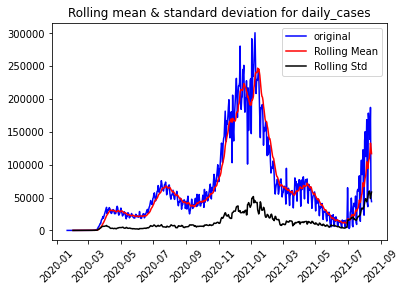

Results of Dickney-Fuller Test:
Test Stastistic                -1.579222
p-value                         0.494022
Lags Used                      14.000000
Number of Observation Used    558.000000
Critical Value (1%)            -3.442124
Critical Value (5%)            -2.866734
Critical Value (10%)           -2.569536
dtype: float64


In [116]:
test_stationarity(new_df,'daily_cases')

Dickney Fuller theory null theory is that the data is stationary. 
p-value is 0.49 which means that we failed to rejet the null hypothesis which is at 0.05 level. So, we have to transform to make the data stationary. Various methods are transformation, smoothing, differencing. 


##Plotting moving average to smooth the trend.

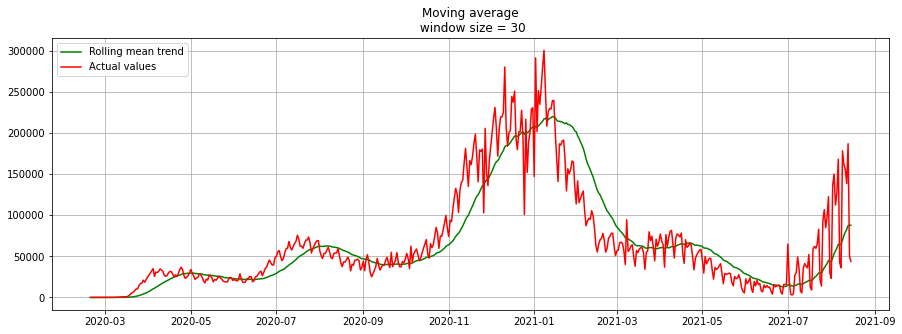

In [117]:
def plotMovingAverage(
    series, window, plot_intervals=False,
):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    plt.plot(series[window:], label="Actual values",color = 'red' )
    plt.legend(loc="upper left")
    plt.grid(True)

plotMovingAverage(new_df['daily_cases'], 30)

##Eliminating Trend and seasonality


###Creating a function that plots the transformed data.

In [118]:
def plot_transformed_data(df, ts, ts_transform):
  """
  Plot transformed and original time series data
  """
  # Plot time series data
  f, ax = plt.subplots(1,1)
  ax.plot(df[ts])
  ax.plot(df[ts_transform], color = 'red')

  # Add title
  ax.set_title('%s and %s time-series graph' %(ts, ts_transform))

  # Rotate x-labels
  ax.tick_params(axis = 'x', rotation = 45)

  # Add legend
  ax.legend([ts, ts_transform])
  
  plt.show()
  plt.close()
  
  return

###Adding transformation to the dataset

In [119]:
new_df['case_log'] = new_df['daily_cases'].apply(
    lambda x: np.log(x))

In [133]:
new_df['case_moving_log'] = new_df['case_log'].rolling(window = 30,
                                               center = False).mean()

df_transform = new_df.dropna() 
df_transform.head()           

,cases,deaths,daily_cases,daily_death,case_log,case_moving_log
date,,,,,,
2020-03-28,123966,2300,21066.0,530.0,9.955416,6.321708
2020-03-29,142486,2718,18520.0,418.0,9.826607,6.595614
2020-03-30,163955,3368,21469.0,650.0,9.974365,6.874445
2020-03-31,188461,4304,24506.0,936.0,10.106673,7.114988
2020-04-01,215391,5325,26930.0,1021.0,10.200996,7.362602


In [121]:
df_transform['ts_log_diff'] = new_df['case_log'].diff()

/usr/local/lib/python3.7/dist-packages/pandas/core/algorithms.py:2001: RuntimeWarning:

invalid value encountered in subtract

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



###Plotting the transformation

Main objective is to check if these new transformations pass the stationarity test.

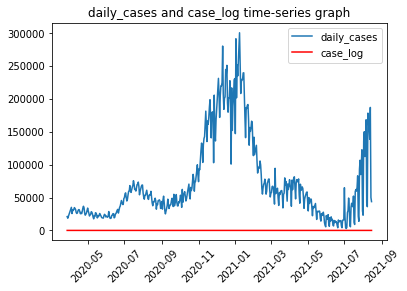

In [122]:
# Plot data
plot_transformed_data(df = df_transform, 
                      ts = 'daily_cases', 
                      ts_transform = 'case_log')

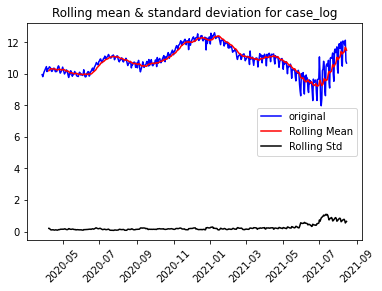

Results of Dickney-Fuller Test:
Test Stastistic                -2.536779
p-value                         0.106780
Lags Used                      18.000000
Number of Observation Used    487.000000
Critical Value (1%)            -3.443849
Critical Value (5%)            -2.867493
Critical Value (10%)           -2.569941
dtype: float64


In [123]:
test_stationarity(df_transform,'case_log')

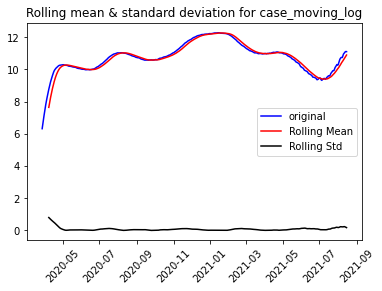

Results of Dickney-Fuller Test:
Test Stastistic                -2.408506
p-value                         0.139350
Lags Used                      16.000000
Number of Observation Used    489.000000
Critical Value (1%)            -3.443794
Critical Value (5%)            -2.867469
Critical Value (10%)           -2.569928
dtype: float64


In [124]:
test_stationarity(df_transform,'case_moving_log')

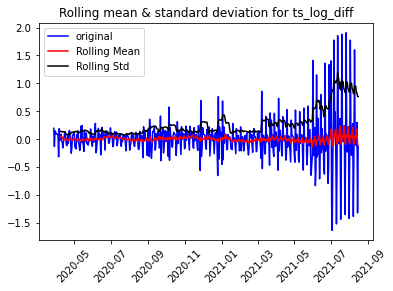

Results of Dickney-Fuller Test:
Test Stastistic                -2.887041
p-value                         0.046876
Lags Used                      17.000000
Number of Observation Used    488.000000
Critical Value (1%)            -3.443821
Critical Value (5%)            -2.867481
Critical Value (10%)           -2.569934
dtype: float64


In [125]:
test_stationarity(df_transform,'ts_log_diff')

#Finally, modelling the date with Prophet.

In [126]:
from fbprophet import Prophet
import datetime
from datetime import datetime

In [127]:
def days_between(d1, d2):
    """Calculate the number of days between two dates.  D1 is start date (inclusive) and d2 is end date (inclusive)"""
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days + 1)

##Setting the value required for Prophet

In [128]:
date_column = 'date'
metric_column = 'ts'
table = df_transform
start_training_date = '2020-07-03'
end_training_date = '2021-08-08'
start_forecasting_date = '2021-08-09'
end_forecasting_date = '2021-10-31'
year_to_estimate = '2021'


future_num_points = days_between(start_forecasting_date,
                                 end_forecasting_date)
cap = None
growth = 'linear'
changepoint_prior_scale = 0.05 
n_changepoints = 25 
changepoints = None 
holidays_prior_scale = 10 
interval_width = 0.8 
mcmc_samples = 0
holidays = None
daily_seasonality = True

##Selecting columns and tweaking as per requirement

In [129]:
# get relevant data 
df_prophet = df_transform[['case_log']] 

# reset index
df_prophet = df_prophet.reset_index()

# rename columns
df_prophet = df_prophet.rename(columns = {'date': 'ds', 'case_log': 'y'})

# Change 'ds' type from datetime to date (necessary for FB Prophet)
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Change 'y' type to numeric (necessary for FB Prophet)
df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='ignore')

##Creating a forecast model with tweaks as required.

In [130]:
def create_daily_forecast(df,
                          holidays,
                          growth,
                          n_changepoints = 25,
                          changepoint_prior_scale = 0.05,
                          changepoints = None,
                          holidays_prior_scale = 10,
                          interval_width = 0.8,
                          mcmc_samples = 1,
                          future_num_points = 10, 
                          daily_seasonality = True):
  df_ = df.copy()
  model = Prophet(growth=growth,
                  n_changepoints = n_changepoints,
                  changepoints = changepoints,
                  holidays = holidays,
                  holidays_prior_scale = holidays_prior_scale,
                  interval_width = interval_width,
                  mcmc_samples = mcmc_samples,
                  daily_seasonality = daily_seasonality)
  model.fit(df_)

  future = model.make_future_dataframe(periods = future_num_points)

  future_data = model.predict(future)

  model.plot(future_data)
  model.plot_components(future_data)

  return future_data

##Forecasting

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


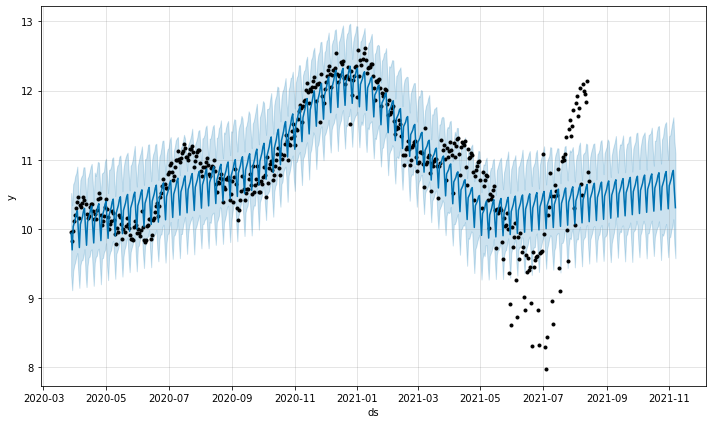

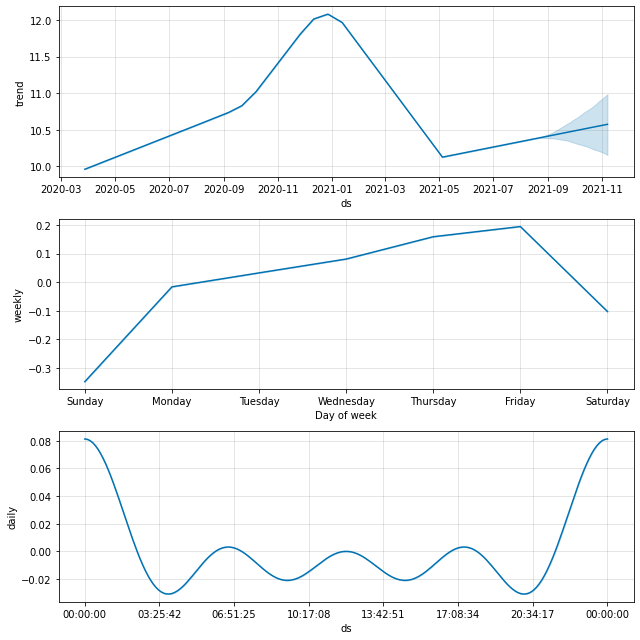

In [131]:
new_forecast = create_daily_forecast(df_prophet,
                             holidays,
                             growth,
                             n_changepoints,
                             changepoint_prior_scale,
                             changepoints, 
                             holidays_prior_scale,
                             interval_width,
                             mcmc_samples,
                             future_num_points, 
                             daily_seasonality)

#Conclusion

As one can see that the daily covid cases are forecasted to be growing. 

This is the trend that is observed in USA right now. 